## [모듈 2.2] 사용자 정의 스크립트 (Bring Your Own Script) 로 모델 훈련

이 노트북은 아래와 같은 작업을 합니다.
- 데이터 다운로드 및 로딩
- 피쳐 엔지니어링
- 훈련, 테스트 데이터 세트로 분리
- 데이터 파일을 로컬 및 S3에 저장
- 모델 훈련 위한 훈련 모드 파라미터 조정. 
    - **[중요] 아래 두가지 모드를 (1) 로컬 모드, (2) 클라우드 모드 로 순서대로 하세요. 해당 부분을 주석 표시하시면서 하시면 됩니다.**
    - 로컬 모드 선택시 로컬 노트북 인스턴스에서 훈련
    - 클라우드 모드 선택시 클라우드 인스턴스에서 훈련
- SK Learn Estimator 생성
- 훈련 코드 설명 (src/train.py)
- 모델 아티펙트 얻기

이 노트북의 주요한 내용 및 예제 코드는 아래를 참조 하세요.

Using Scikit-learn with the SageMaker Python SDK
- https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html

Iris Training and Prediction with Sagemaker Scikit-learn
- https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/scikit_learn_iris/scikit_learn_estimator_example_with_batch_transform.ipynb

In [29]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np


---
## Data 다운로드 및 로딩

데이터에 대한 자세한 정보는 여기를 참조 하세요. [here](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html)


In [30]:
# !wget http://robjhyndman.com/data/gasoline.csv

,thousands_barrels
0,6621.0
1,6433.0
2,6582.0
3,7224.0
4,6875.0


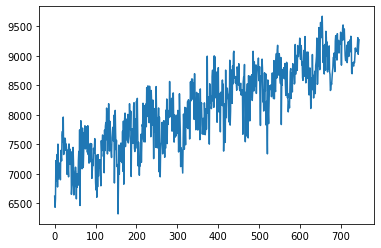

In [31]:
raw_gas = pd.read_csv('gasoline.csv', header=None, names=['thousands_barrels'])
display(raw_gas.head())
plt.plot(raw_gas)
plt.show()

## 피쳐 엔지니어링

In [32]:
def make_feature_engineering(gas):
    gas['thousands_barrels_lag1'] = gas['thousands_barrels'].shift(1)
    gas['thousands_barrels_lag2'] = gas['thousands_barrels'].shift(2)
    gas['thousands_barrels_lag3'] = gas['thousands_barrels'].shift(3)
    gas['thousands_barrels_lag4'] = gas['thousands_barrels'].shift(4)
    gas['trend'] = np.arange(len(gas))
    gas['log_trend'] = np.log1p(np.arange(len(gas)))
    gas['sq_trend'] = np.arange(len(gas)) ** 2
    weeks = pd.get_dummies(np.array(list(range(52)) * 15)[:len(gas)], prefix='week')
    gas = pd.concat([gas, weeks], axis=1)
    
    return gas

gas = make_feature_engineering(raw_gas)

## 훈련, 테스트 데이터 세트로 분리

데이터 분리:
- 최근 4주의 데이터를 설명 변수로 만들었기에, 최초 4개의 레코드는 삭제 합니다. (왜냐하면 4개의 설명 변수가 하나 이상은 NULL 이이서 입니다.)
- 데이터를 8:2 비율로 훈련, 테스트 데이터로 분리 합니다.
- 테스트 데이터에 대해서 타겟 변수를 설명 변수와 분리 합니다. 


이전 노트북과의 차이점은 훈련에 사용을 할 데이터를 train_X, train_y로 구분하지 않고, 실제 훈련 코드(src/train.py) 에서 이를 분리 합니다.

In [33]:
test_border=0.8
n_lags = 4 ; label = 'thousands_barrels'   
gas = gas.iloc[n_lags:, ]
# split_train = int(len(gas) * train_border)
split_test = int(len(gas) * test_border)

train = gas[:split_test]
# val = gas[split_train:split_test]
test = gas[split_test:]
test_y = gas[label][split_test:]
test_X = gas.drop(label, axis=1).iloc[split_test:, ].to_numpy()


In [34]:
print(train.shape)
print(test_X.shape)
print(test_y.shape)


(592, 60)
(149, 59)
(149,)


### 데이터 파일을 로컬 및 S3에 업로드

- 훈련에 필요한 데이터는 로컬모드시에 로컬/S3 에 있는 것을 모두 사용할 수 있습니다. 
- 클라우드 모드시에는 S3에 있는 데이터만 사용이 가능하므로 여기서는 로컬 및 S3에 모두 데이터를 저장 합니다.

In [35]:
import sagemaker 

# 로컬에 파일 저장
def save_local(df,dir, file_name ):
    os.makedirs(dir, exist_ok=True)
    file_name_path = os.path.join(dir, file_name)
    df.to_csv(file_name_path, index=False,  header=None, float_format='%.3f')
    print(f'{file_name_path} is saved')
    
    return file_name_path

train_dir = 'fe_data/train'
train_file_path = save_local(train,dir=train_dir, file_name='train.csv' )

test_dir = 'fe_data/test'
test_file_path = save_local(test, dir=test_dir, file_name='test.csv' )

# 로컬 파일을 S3에 업로드
from p_utils import upload_s3

# S3 prefix
prefix = 'Scikit-byos'
    
bucket = sagemaker.Session().default_bucket()
prefix = 'demandforecasting'
train_file_name = 'test/train/train.csv'
s3_train_path = upload_s3(bucket, train_file_path, prefix)
s3_test_path = upload_s3(bucket, test_file_path, prefix)


fe_data/train/train.csv is saved
fe_data/test/test.csv is saved
s3_path:  s3://sagemaker-ap-northeast-2-057716757052/demandforecasting/fe_data/train/train.csv
s3_path:  s3://sagemaker-ap-northeast-2-057716757052/demandforecasting/fe_data/test/test.csv


## 모델 훈련: 로컬 모드 파라미터
**아래 instance_type 에 따라서 로컬 모드, 클라우드 모드로 제어 합니다.
처음에는 로컬모드, 잘 동작하면 클라우드 모드로 바꾸어서 해보세요.**
- 로컬 모드이면 세이지 메이커의 로컬 세션이 할당이 됩니다.
    - 세이지 노트북 인스턴스에서 Docker Container가 생성이 되어서 훈련을 합니다.
- 클라우드 모드이면 세이지 메이커에의 세션이 할당이 되어서, 클라우드에 훈련이 진행 됩니다.
    - 클라우드 상에서 EC2 인스턴스가 생성이 되고, 이 EC2안에서 Docker Container가 생성이 되어서 훈련 합니다.

In [36]:
instance_type = 'local'
# instance_type="ml.c4.xlarge"

In [37]:
from sagemaker import local

if instance_type == 'local':
    sess = local.LocalSession()
else:
    sess = sagemaker.Session()

### SK Learn의 Estimator 오브젝트를 생성

아래는 SageMaker 의 SK Learn의 Estimator 오브젝트를 생성합니다. 자세한 내용은 아래 문서를 참조 히세요. [Using Scikit-learn with the SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html)

아래  SK Learn의 Estimator 생성자에 들어가는 인자의 설명 합니다.
- entry_point: 훈련 코드가 저장되어 있는 경로 입니다.이 훈련 코드는  모델을 정의하고, 모델을 훈련을 하는 스크립트 입니다.    
- framework_version: SK Learn의 버전입니다.
- instance_type: 어떤 인스턴스 타입을 사용할지를 결정 합니다.
- role: 세이지 메이커가 훈련을 하면서 S3 같은 서비스에 접근할때 사용하는 역할 입니다. 만약에 role이 S3 에 접근 권한이 없으면 에러가 발생합니다.
- sagemaker_session: 로컬 모드인지, 클라우드 모드인지를 결정 합니다.
- hyperparameters: 필요한 하이퍼 파리미터의 값을 전달하여 훈련 코드에서 사용 합니다,    

- fit(): 실제로 훈련을 실행하는 함수 입니다. 인자로서 훈련에 사용되는 데이터가 인자로 사용이 됩니다. logs 는 클라우드로 훈련시에 노트북에 로그를 보이지 말라는 의미 입니다.



### 훈련 코드 설명 src/train.py
세이지 메이커의 파이썬 사용자 정의 스크립트 방식을 이용하기 위해서는 반드시 아래 구문이 필요 합니다
**실제로 train.py를 작성시에는 아래의 코드 템플릿을 사용하시고, 로컬 모드로 실행하여 코드를 완성하신 후에 클라우드 모드에서 최종 훈련 하세요.**
```python
if __name__ == '__main__':
    args = parse_args()  # 파라미터 얻음  
```    
아래의 코드의 주석을 참조 하세요.

```python
def parse_args():   
    '''
    커맨드 인자로 넘어온 정보를 파싱한다.
    아래 args를 파싱한 결과는 아래와 같습니다.
    args:  Namespace(alpha=1.5,
    model_dir='/opt/ml/model',train='/opt/ml/input/data/train')
    '''
    parser = argparse.ArgumentParser()

    # Hyperparameters 의 데이터를 파싱하여 args 오브젝트에 저장 합니다.
    parser.add_argument('--alpha', type=float, default=3)

    # 모델은 훈련후에 model_dir='/opt/ml/model' 로 저장이 됩니다. 이후에 자동으로 S3에 업로드가 됩니다.
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    
    # sklearn_estimator.fit({'train': s3_train_path}, logs=False) 에서 기술한
    # 입력 데이터는 S3로 부터 train='/opt/ml/input/data/train' 경로로 다운로드 됩니다.
    # 이후에 이 로컬 경로에서 데이터를 가져와서 훈련을 합니다.
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args = parser.parse_args()
    print("args: ", args)
    
    return args

if __name__ == '__main__':
    args = parse_args()  # 파라미터 얻음  
    train_y, train_X = handle_input_data(args) # 훈련 데이터를 traiy_y, train_X 로 분리 합니다.
    
    ridge_model = train(args, train_X, train_y, model="ridge") # 데이터를 가지고 훈련 합니다.
    model_name = 'model.joblib' #저장할 모델 이름 입니다.
    save_model(ridge_model, args.model_dir, model_name) #args.model_dir 에 명시된 경로에 모델 저장


```



In [38]:
from sagemaker import get_execution_role

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
script_path = 'src/train.py'


sklearn_estimator = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type= instance_type,
    role=role,
    sagemaker_session= sess,
    hyperparameters={'alpha': 1.5}
)

In [39]:
%%time
sklearn_estimator.fit({'train': s3_train_path}, logs=False)

Creating tmprxx55wcz_algo-1-r9sb2_1 ... 
Attaching to tmprxx55wcz_algo-1-r9sb2_12mdone
algo-1-r9sb2_1  | 2020-12-06 02:20:31,813 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
algo-1-r9sb2_1  | 2020-12-06 02:20:31,816 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-r9sb2_1  | 2020-12-06 02:20:31,823 sagemaker_sklearn_container.training INFO     Invoking user training script.
algo-1-r9sb2_1  | 2020-12-06 02:20:32,975 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-r9sb2_1  | 2020-12-06 02:20:32,987 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-r9sb2_1  | 2020-12-06 02:20:32,996 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
algo-1-r9sb2_1  | 2020-12-06 02:20:33,003 sagemaker-training-toolkit INFO     Invoking user script
algo-1-r9sb2_1  | 
algo-1-r9sb2_1  | Training Env:
algo-1-r9s

## 모델 아티팩트 얻기

이 부분은 아래와 같은 작업을 합니다.

- S3에 업로드된 모델 아티펙트를 다운로드 합니다. (예: s3://sagemaker-ap-northeast-2-057716757052/sagemaker-scikit-learn-2020-12-06-02-20-27-949/model.tar.gz to model/model.tar.gz)
- 로컬에 다운로드된 모델 아티펙트를 압축 해제하여 모델 아티펙트를 얻습니다.
- 이후 경로를 저장하여 다음 노트북에서 사용 합니다.

In [40]:
local_model_dir = 'model'
os.makedirs(local_model_dir, exist_ok=True)
s3_model_dir = sklearn_estimator.model_data

In [41]:
!aws s3 cp {s3_model_dir} {local_model_dir}/model.tar.gz
!tar -xzf {local_model_dir}/model.tar.gz -C {local_model_dir}

download: s3://sagemaker-ap-northeast-2-057716757052/sagemaker-scikit-learn-2020-12-06-02-20-27-949/model.tar.gz to model/model.tar.gz


In [42]:
# local_model_path = os.path.join(local_model_dir, 'model.joblib')
%store s3_model_dir
%store test_file_path
%store local_model_dir

Stored 's3_model_dir' (str)
Stored 'test_file_path' (str)
Stored 'local_model_dir' (str)
